# 1. Experimental frame setup

## 1.1 Dataset
### 1.1.1 UrbanSound8K
Download the dataset from https://serv.cusp.nyu.edu/projects/urbansounddataset/download-urbansound8k.html

## 1.2 Feature extraction
Starting from the $\texttt{.wav}$ files of the UrbanSound8K dataset, we use the $\texttt{librosa}$ library to extract the log-powered mel-spectrograms.
![Mel Spectrogram](https://dtudk-my.sharepoint.com/personal/s134416_win_dtu_dk/_layouts/15/guestaccess.aspx?docid=09c67c0b2c0fd47a0bd57f98c2745d03b&authkey=AYQocyDrB47VOhMvMUIxo_Q&e=5efe80a2e6be40248c0962d2f37ef631)

We save the extracted features and labels in two $\texttt{.npy}$ files that we can easily load in memory. This is crucial in the process of cross-validation, where we would otherwise lose a lot of time reloading the files with $\texttt{librosa}$.

If you don't want to run the preprocessor, you can download the long variant (101 frames) of the 60 bands extracted features [here](https://dtudk-my.sharepoint.com/personal/s134416_win_dtu_dk/_layouts/15/guestaccess.aspx?folderid=07889eea02b1746d0ad30d5aa4ed2691d&authkey=AYHLMZEoCu8jzYDf01l6qMs&e=7710d1abfdc245998150ceecc04651de)

In [1]:
from preprocessor import preprocessor

pp = preprocessor(parent_dir='data/UrbanSound8K')

train_dirs = ["fold1", "fold2", "fold3", "fold4", "fold5", "fold6", "fold7", "fold8", "fold9", "fold10"]

#pp.save_fts_lbs(train_dirs=train_dirs, save_path='extracted/short_60', segment_size=20480, overlap=0.5, bands=60, frames=41)
pp.save_fts_lbs(train_dirs=train_dirs, save_path='extracted/long_60', segment_size=51200, overlap=0.9, bands=60, frames=101)
#pp.save_fts_lbs(train_dirs=train_dirs, save_path='extracted/short_200', segment_size=20480, overlap=0.5, bands=200, frames=41)
#pp.save_fts_lbs(train_dirs=train_dirs, save_path='extracted/long_200', segment_size=51200, overlap=0.9, bands=200, frames=101)

extracting fold1
extracting fold2
extracting fold3
extracting fold4
extracting fold5
extracting fold6
extracting fold7
extracting fold8
extracting fold9
extracting fold10


## 1.3 Datasets with overlaying sound events 

We created two datasets called **50-50** and **90-10**. 
- **50-50**: composed by pairs of sounds overlayed and balanced, taking into account all the possible combination of classes (for undersampled classes data are used multiple times, adding white noise at the second time they are encountered). 
- **90-10**: composed by pairs of sounds overlayed and balanced, taking into account all the possible combination of classes, with the second sound attenuated by 30dB. Besides taking into account all the possible combination of classes and the different volumes, the corresponding  is really similar to the one for 50-50 creation.

The scripts can be found in the GitHub repo in the folder called "Overlaying_datasets_creation_scripts". The file "main_script_overlapping_segments.py" contains the code for running those scripts and it is displayed below. **Note** that for handling audio files we used a library called PyDub (*https://www.pydub.com*) and it is necessary to install and other dependecies to run it. However, we provide below also the link for downloading the already extracted features of the overlaying datasets. 

Moreover, in order to run the scripts you should have downloaded UrbanSound8K, have the csv file describing its metadata, and the original_path (path containing the folders of urbansound8k) and destination_path (path for accomodating the folders for the new datasets clips) should be present in your directory. Furthermore, not all the UrbanSound8K files are in 44100Khz, necessary format for PyDub to handle those. Thus, once urbansound8k is downloaded, the files should be converted to 441000 folder by folder, with the following bash code line (after having created the folders for accomodating the overlaying files, called, for example *folder1_overlap*), which uses *ffmpeg* (*https://www.ffmpeg.org/*) for converting the files:

In [ ]:
for aud in *.wav; do ffmpeg -i “$aud” -ar 44100 “folder1_overlap/${aud%}“; done 

In [ ]:
##install some necessary libraries
!pip install pydub
!pip install wavio
!pip install scipy
!pip install wave

In [ ]:
import pandas
import sys
import wave
import math
import struct
import random
import argparse
from itertools import *
import pydub 
from pydub import AudioSegment
from pydub import generators as g
import scipy.io
from scipy.io import wavfile
import soundfile as sf
import wavio
import overlap_segments_w_wn as ov_5050
import overlap_segments_w_wn_90_10volume as ov_9010


#run script for creating 50-50 dataset
ov_5050.overlay_50_50_creation()

#run script for creating 90-10 dataset
ov_9010.overlay_90_10_creation()

You can download the extracted features for the 50-50 dataset from [here](https://dtudk-my.sharepoint.com/personal/s134416_win_dtu_dk/_layouts/15/guestaccess.aspx?folderid=0dcb73b75951949c5af09ea01921dad9b&authkey=AfCysDQgSasEvzjurBnbqaY&e=54f790634d934ee18dc83c19ea540b96)

You can download the extracted features for the 90-10 dataset from [here](https://mega.nz/#F!IbpCSDgK!ZDecPNNqeDowBm_CWz2hPQ)

A sample of the actual datasets created (just one folder, with the same organization paths as in the scripts in the github repo) can be downloaded from [here](https://mega.nz/#!EeBQBYKJ!bIazdBTkCgvHSP-10Tj2kL4Px-jQaKf1S1gMN9ssC8A)

# 2. Single label model


In [4]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers import Conv2D, BatchNormalization
from keras.layers import MaxPooling2D
from keras import regularizers, initializers
from keras.optimizers import sgd
from keras import backend as K

def uniform(scale):
        return initializers.uniform(minval=-scale, maxval=scale)

def normal(stdev):
        return initializers.normal(stddev=stdev)
def constant(const):
        return initializers.constant(value=const)
def piczak_CNN(input_dim, output_dim,
        activation='relu',
        metrics="accuracy", loss='categorical_crossentropy'):
    """
    This method returns a keras model describing Piczak implementation.

    From Piczak:
    The first convolutional ReLU layer consisted of 80 filters
    of rectangular shape (57x6 size, 1x1 stride) allowing
    for slight frequency invariance. Max-pooling was applied
    with a pool shape of 4x3 and stride of 1x3
    Original implementation in pylearn2 can be found here:
    https://github.com/karoldvl/paper-2015-esc-convnet/blob/master/Code/_Networks/Net-DoubleConv.ipynb
    """
    l2_param = 0.01
    model = Sequential()
    model.add(Conv2D(80, kernel_size=(input_dim[0] - 3, 6), strides=(1, 1),
                     activation=activation,
                     input_shape=input_dim,
                     kernel_initializer=uniform(0.001),
                     bias_initializer=constant(0.1),
                     kernel_regularizer=regularizers.l2(l2_param)))

    model.add(MaxPooling2D(pool_size=(4, 3), strides=(1, 3)))
    model.add(Dropout(0.75))

    model.add(Conv2D(80, kernel_size=(1, 3), strides=(1, 1),
                     activation=activation,
                     kernel_initializer=uniform(0.1),
                     kernel_regularizer=regularizers.l2(l2_param)))

    model.add(MaxPooling2D(pool_size=(1, 3), strides=(1, 3)))

    model.add(Flatten())

    # Layer 1
    model.add(Dense(5000, kernel_initializer=normal(0.01), kernel_regularizer=regularizers.l2(l2_param)))
    model.add(Activation('relu'))
    model.add(Dropout(0.75))

    # layer 2
    model.add(Dense(5000, kernel_initializer=normal(0.01), kernel_regularizer=regularizers.l2(l2_param)))
    model.add(Activation('relu'))
    model.add(Dropout(0.75))

    # layer
    model.add(Dense(output_dim, kernel_initializer=normal(0.01), kernel_regularizer=regularizers.l2(l2_param)))
    model.add(Activation('softmax'))

    if input_dim[1] == 41:
        optimizer = sgd(lr=0.002, momentum=0.9, nesterov=True)
    else:
        if input_dim[1] == 101:
            optimizer = sgd(lr=0.01, momentum=0.9, nesterov=True)
        else:
            raise ValueError("Segment must either have 41 or 101 frames")

    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=[metrics])

    return model
  

## 2.1 Cross Validation
For each model (i.e. short60, long60, short200, long200) we ran 10-fold cross-validation, using eight folders as training data, one folder as validation set and one folder as test set. 

In [6]:
from preprocessor import preprocessor
from keras.callbacks import TensorBoard, EarlyStopping
import numpy as np
from keras import backend as K
import utils

# Define classes (for confusion matrix)
classes = classes = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']

epochs = 150
load_path='extracted/long_60'
train_dirs = []

n_folders = 10
for i in range(1, n_folders + 1):
    train_dirs.append('fold{0}'.format(i))

cvscores = []
#for folds in ((10, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10)):
for folds in [(9, 10)]: #Train only a single fold just for show 
    val_fold = 'fold' + str(folds[0])
    test_fold= 'fold' + str(folds[1])
    # Remove validation and test from train
    train_dirs.remove(val_fold)
    train_dirs.remove(test_fold)

    print("Run {0}: test folder is fold{0}".format(folds[1]) + ", validation folder is fold{0}".format(folds[0]))

    tb = TensorBoard(log_dir='./TensorBoard/long_60/' + 'run{0}'.format(folds[1]))
    es = EarlyStopping(patience=10, verbose=1)

    pp = preprocessor()
    pp.load_extracted_fts_lbs(load_path=load_path, train_dirs=train_dirs, test_fold=test_fold, val_fold=val_fold)   
    print("Data prep completed")

    model = piczak_CNN(input_dim=pp.train_x[0].shape, output_dim=pp.train_y.shape[1])
    print("Model built")
    model.summary()
    model.fit(pp.train_x, pp.train_y, validation_data=[pp.val_x, pp.val_y], epochs=epochs,
               batch_size=1000, verbose=2, callbacks=[es, tb])
    print("Model trained")

    # Save the trained model
    output_model_file = 'models/long60_' + str(epochs) + '_' + str(folds) + '.h5'
    model.save(output_model_file)
    scores = model.evaluate(pp.test_x, pp.test_y, verbose=0)
    print("loss: {0}, test-acc: {1}".format(scores[0], scores[1]))                                                                     
    cvscores.append(scores[1] * 100)      
    # Remove model from memory
    K.clear_session()
    # Add the validation and test again for the next run.
    train_dirs.append(val_fold)
    train_dirs.append(test_fold)
print("Average performance after cross-validation: %.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

Run 10: test folder is fold10, validation folder is fold9
Data prep completed
Model built
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 4, 96, 80)         54800     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 1, 32, 80)         0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 32, 80)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 30, 80)         19280     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 1, 10, 80)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 800)               0         
____________________________________________________

If you want to see the training process, you can start tensorboard by running this command from the root of the project. 

$\texttt{tensorboard --logdir='TensorBoard'}$

Below you can see our final results.

In [7]:
import pandas as pd

df = pd.read_excel('logs/piczak_cv_results.xlsx', sheetname=1)
df.head()

,run1,run2,run3,run4,run5,run6,run7,run8,run9,run10,Average,StDev
short_60,0.631746,0.524219,0.519109,0.614269,0.623094,0.550229,0.555519,0.587509,0.647792,0.675970,0.583721,0.048142
long_60,0.690345,0.671870,0.518753,0.651414,0.683282,0.515301,0.623859,0.548439,0.703675,0.737907,0.634484,0.080128
short_200,0.568919,0.584927,0.511141,0.590961,0.631396,0.576656,0.583974,0.660578,0.658915,0.646573,0.601404,0.047432
long_200,0.639606,0.586811,0.563517,0.670743,0.634963,0.564297,0.609190,0.704243,0.675298,0.601156,0.624982,0.048254


If you haven't run the cross-validation, you can download the trained models for the 101 frames and 60 bands [here](https://dtudk-my.sharepoint.com/personal/s161162_win_dtu_dk/_layouts/15/guestaccess.aspx?folderid=0cf9ad23411344bcc8bb22295fb1747a8&authkey=AU73y6XMKpwbsFP0cOQ4gA4&e=6e503350a63544a58cb03a1b7edec5a4)

## 2.1 Confusion Matrix
The confusion matrix show below is of the best performing model (run 10) from the 101 frames, 60 bands model. This run is also the run shown above.

Confusion matrix, without normalization


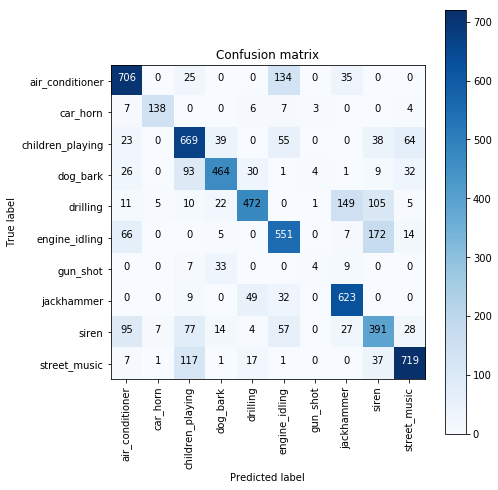

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 7.0)
import confusion_matrix as cm

model_filename = 'models/long60_150_(9, 10).h5'
load_path = 'extracted/long_60'

cm.plot_confusion_matrix(model_filename, load_path, save=True)

plt.draw()

## 2.2 Boxplot
Below is the boxplots of the different runs showing that on average the longer variant (101 frames) perform better than the short variant (41 frames). Furthermore we also see that increasing the resolution of the mel-spectrograms does not increase performance using the described model.

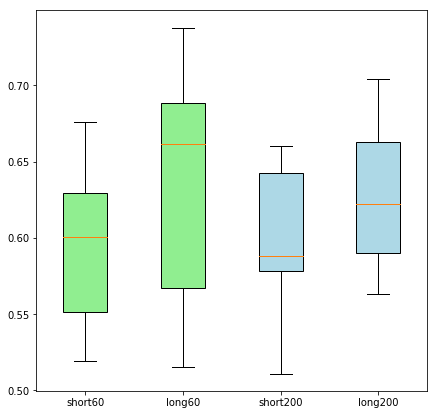

In [6]:
import boxplot as bxplt

file_name = 'logs/piczak_cv_results.xlsx'
colors = ['lightgreen', 'lightgreen', 'lightblue', 'lightblue']
labels = ['short60', 'long60', 'short200', 'long200']

bxplt.draw_boxplot(file_name, colors, labels)

## 2.3 Boxplot: -30dB Overlaying sound 
Below is the boxplot showing the results of the singlelabel performance on overlaying sounds.
We clearly see that by training on the overlaying sounds the performance when testing on overlaying sounds increase as expected. Furthermore we see that the performance after training on the overlaying sounds with only a single label (the loudest) the performance decreases when testing on non overlaying sounds. We believe that this decrease is due to wrongly labelling the lower of the two sounds, thereby making the network learn a wrong representation of the correct sound.

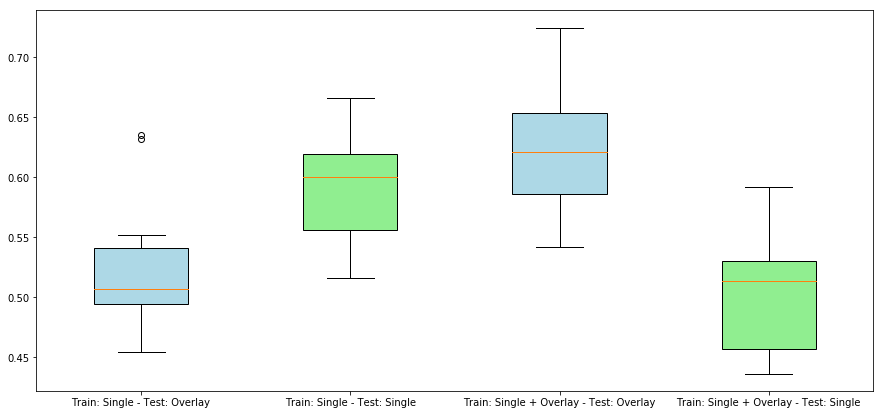

In [9]:
file_name = 'logs/overlay_results.xlsx'
colors = ['lightblue', 'lightgreen','lightblue', 'lightgreen']
labels = ['Train: Single - Test: Overlay', 'Train: Single - Test: Single','Train: Single + Overlay - Test: Overlay', 'Train: Single + Overlay - Test: Single']
plt.rcParams['figure.figsize'] = (15.0, 7.0)
bxplt.draw_boxplot(file_name, colors, labels)

# Multilabel classification

For the multilabel classification task we adjusted the model by changing the output layer from softmax to sigmoid, and using binary cross-entropy as loss function. 

In [1]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers import Conv2D, BatchNormalization
from keras.layers import MaxPooling2D
from keras import regularizers, initializers
from keras.optimizers import sgd
from keras import backend as K

def piczak_CNN_multi(input_dim, output_dim,
               activation='relu', optimizer="adam",
               metrics="accuracy", loss='binary_crossentropy'):

    model = Sequential()
    # First convolutional layer
    model.add(Conv2D(80, kernel_size=(57, 6,), strides=(1, 1),
                     activation=None,
                     input_shape=input_dim,
                     kernel_regularizer=regularizers.l2(0.001)))

    # Max pooling
    model.add(MaxPooling2D(pool_size=(4, 3), strides=(1, 3)))
    
    # Added batchnormalization 
    model.add(BatchNormalization())
    
    model.add(Activation('relu'))
    
    # Dropout
    model.add(Dropout(0.5))
    
    # Second convolutional layer
    model.add(Conv2D(80, kernel_size=(1, 3), strides=(1, 1),
                     activation=None,
                     input_shape=input_dim))

    # Maxpooling 
    model.add(MaxPooling2D(pool_size=(1, 3), strides=(1, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    # Flatten the representation to one dimension 
    model.add(Flatten())

    # Fully connected layer 1
    model.add(Dense(5000))
    model.add(Dropout(0.5))
    model.add(Activation('relu'))

    # Fully connected layer 2
    model.add(Dense(5000))
    model.add(Dropout(0.5))
    model.add(Activation('relu'))

    # layer
    model.add(Dense(output_dim))

    # Sigmoid output layer
    model.add(Activation('sigmoid'))
    
    # Functionality for printing the structure of the model
    inp = model.input  # input placeholder
    outputs = [layer.output for layer in model.layers]  # all layer outputs
    functor = K.function([inp] + [K.learning_phase()], outputs)  # evaluation function

    print(outputs)
    print(functor)

    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=[metrics])

    print("Model built")

    return model
print("done")  

Using TensorFlow backend.


done


## Evaluation 
To evaluate the multilabel classifier we use F1-score and zero-one loss imported from scikit-learn.

In [3]:
from sklearn.metrics import f1_score, hamming_loss, zero_one_loss
import matplotlib.pyplot as plt
from pandas_confusion import ConfusionMatrix
import utils
import numpy as np

def evaluateModel(pp, preds, fold):
    print("Evaluation")
    # ************ PROCESSING THE PREDICTIONS
    
    # Transforming predictions at threshold 0.5
    preds[preds >= 0.5] = 1
    preds[preds < 0.5] = 0
    
    print("F1 SCORE:")
    print(f1_score(pp.test_y, preds, average=None))
    
    print("Hamming Loss:")
    print(hamming_loss(pp.test_y, preds))
    
    print("Zero-one loss:")
    print(zero_one_loss(pp.test_y, preds))
    
    # Transforming labels into representation with all classes and combined classes
    utils.classes_number_mapper()
    y_test_preds = utils.from_plus_to_one_hot(np.array(pp.test_y))
    preds_transf = utils.from_plus_to_one_hot(np.array(preds))
    cm = ConfusionMatrix(np.array(y_test_preds).argmax(1), np.array(preds_transf).argmax(1))
    ax = cm.plot()
    ax.set_xticklabels(utils.classes, rotation="vertical")
    ax.set_yticklabels(utils.classes)
    plt.savefig("conf_{0}.png".format(fold))
    

As for the singlelabel classification task we applied the cross validation technique based on the folder structure of the dataset.

In [4]:
from keras.callbacks import TensorBoard, EarlyStopping
from preprocessor import preprocessor
import numpy as np
from keras import backend as K

def piczac_cross_validation(epochs, load_path):
    train_dirs = []

    n_folders = 10

    for i in range(1, n_folders + 1):
        # Appending names of the folders that we want to load files from
        train_dirs.append('folder{0}_overlap'.format(i))

    #for fold in ((10, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10)):
    for fold in [(9, 10)]: #Train only a single fold just for show 
        
        # selecting test and validation folder
        val_fold = 'folder{0}_overlap'.format(fold[0])
        test_fold = 'folder{0}_overlap'.format(fold[1])
    
        # Removing val_fold and test_fold to ensure that we do not train on any of this data
        train_dirs.remove(val_fold)
        train_dirs.remove(test_fold)

        # Set parent dir to be the root location of the extracted features
        pp = preprocessor(parent_dir='../../data/UrbanSound8K/audio')
    
        # Loading the extracted features
        pp.load_extracted_fts_lbs(train_dirs=train_dirs, val_fold=val_fold, test_fold=test_fold, load_path=load_path)
    
        # Creating the model
        model = piczak_CNN_multi(input_dim=pp.train_x[0].shape, output_dim=pp.train_y.shape[1])
  
        tb = TensorBoard(log_dir='./TensorBoard/' + 'overlap_run{0}'.format(fold[1]))
        es = EarlyStopping(patience=10, verbose=1)

        # Training the model
        model.fit(pp.train_x, pp.train_y, validation_data=[pp.val_x, pp.val_y], epochs=epochs, batch_size=1000, verbose=2, callbacks=[tb, es])
    
        
        # Save the trained model
        output_model_file = 'multi5050' + str(epochs) + '_' + str(fold) + '.h5'
        model.save(output_model_file)
        
        # Testing the model
        preds = model.predict(pp.test_x)
        
        # evaluating the model predictions
        evaluateModel(pp,preds, fold)
        
        # cleanup
        K.clear_session()
    
        # Appending the folders such that they are present in train_dirs at the next fold
        train_dirs.append(val_fold)
        train_dirs.append(test_fold)


In [5]:
import tensorflow as tf
import utils # Utility script
from keras import backend as K

print("main")

# Setting up the utils functionality for creating a confusion matrix
utils.classes_number_mapper()

K.clear_session()
# Running the cross validation method
# Specify the load_path (root folder) in which the folders for the extracted features are stored
load_path = "../UrbanSound8K/audio/extracted_overlapping_50/audio_overlap"
piczac_cross_validation(150, load_path)


main
[<tf.Tensor 'conv2d_1/BiasAdd:0' shape=(?, 4, 36, 80) dtype=float32>, <tf.Tensor 'max_pooling2d_1/MaxPool:0' shape=(?, 1, 12, 80) dtype=float32>, <tf.Tensor 'batch_normalization_1/cond/Merge:0' shape=(?, 1, 12, 80) dtype=float32>, <tf.Tensor 'activation_1/Relu:0' shape=(?, 1, 12, 80) dtype=float32>, <tf.Tensor 'dropout_1/cond/Merge:0' shape=(?, 1, 12, 80) dtype=float32>, <tf.Tensor 'conv2d_2/BiasAdd:0' shape=(?, 1, 10, 80) dtype=float32>, <tf.Tensor 'max_pooling2d_2/MaxPool:0' shape=(?, 1, 3, 80) dtype=float32>, <tf.Tensor 'batch_normalization_2/cond/Merge:0' shape=(?, 1, 3, 80) dtype=float32>, <tf.Tensor 'activation_2/Relu:0' shape=(?, 1, 3, 80) dtype=float32>, <tf.Tensor 'flatten_1/Reshape:0' shape=(?, ?) dtype=float32>, <tf.Tensor 'dense_1/BiasAdd:0' shape=(?, 5000) dtype=float32>, <tf.Tensor 'dropout_2/cond/Merge:0' shape=(?, 5000) dtype=float32>, <tf.Tensor 'activation_3/Relu:0' shape=(?, 5000) dtype=float32>, <tf.Tensor 'dense_2/BiasAdd:0' shape=(?, 5000) dtype=float32>, <tf

#### Loading trained models
In the previous cell we saved the trained model. <br>
Having saved a model allows one to load the model and continue training on new data or testing the model.
This will be demonstrated in the following code cell.

In [6]:
from keras.models import load_model
from keras import backend as K
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from preprocessor import preprocessor
K.clear_session()
def evaluateSavedModel():
    
    # Load the previously saved model
    model = load_model("multi5050150_(9, 10).h5")
    
    # Setup preprocessor for loading extracted features
    pp = preprocessor(parent_dir='../UrbanSound8K/audio')
    
    
    # extracted features that should be loaded to calculate mean and std values
    train_dirs = ["folder1_overlap", "folder2_overlap", "folder3_overlap",
                  "folder4_overlap", "folder5_overlap", "folder6_overlap",
                  "folder7_overlap", "folder8_overlap"]

    
    # Load features
    test_fold = "folder10_overlap"
    val_fold = "folder9_overlap"
    load_path = "../UrbanSound8K/audio/extracted_overlapping_50/audio_overlap"
    
    pp.load_extracted_fts_lbs(train_dirs=train_dirs, val_fold=val_fold, test_fold=test_fold, load_path=load_path)
    
    # To continue training on a model, we can fit to more training data
    # model.fit(pp.train_x, pp.train_y,validation_split=.1, epochs=25,
    #           batch_size=256, verbose=2, callbacks=[tb])



    print("model evaluation")
    scores = model.evaluate(pp.test_x, pp.test_y, verbose=2)
    print("loss: {0}, test-acc: {1}".format(scores[0], scores[1]))

    # Make predictions
    preds = model.predict(pp.test_x)

    # Evaluate predictions
    evaluateModel(pp, preds, test_fold)

evaluateSavedModel()

model evaluation
loss: 0.4039917779149431, test-acc: 0.8499091761039965
Evaluation
F1 SCORE:
[ 0.44237288  0.74496644  0.38110488  0.62167689  0.52207591  0.65855404
  0.66342412  0.75081967  0.37271854  0.56046706]
Hamming Loss:
0.15009090909090908
Zero-one loss:
0.858484848485


The results show that we are predicting approximately 14% exact match. Furthermore, we can see from the F1-score of the individual classes that we are performing quite well for certain classes (1,3,5,6,7).<br>
These results are also depicted in the confusion matrix.

![Confusionmatrix](conf_folder10_overlap.png)

<b>The confusion matrix</b> for the multilabel classifier is constructed by having both the single labels and combined labels on the axis. This is such that we can recognize when the classifier predicts one of the two sound events. <br>
As we are testing on multilabelled data, we don't have any samples with a single label as true label. <br>
In the diagonal we see the exact matches, and the small diagonal lines and straight columns at the left side of the confusion matrix indicates that the model has a partially correct result, predicting one of the two sound events present. 

An <i>xxx</i> label is also shown in the confusion matrix, this is to indicate that the model did not make any predictions for a sample.

### Pretraining using single label data
To see if the multilabel classifier would benefit from initially learning the representation of each single label in the dataset, we pretrained a model on the UrbanSound8K dataset.<br>
This pretrained model was then loaded and we continued to train on the overlapping 50-50 dataset. And finally tested on one of the folders from the 50-50 dataset. <br>
An important note is that we left out the same two folders of the UrbanSound8K in the pretraining phase as was used as validation and test set later.<br>

The results from this was the following:

<b>F1-Score</b> = [0.36 **0.75** **0.47** 0.48 0.44 0.63 **0.68** 0.67 **0.67** **0.67**] <br>
<b>Zero-one loss</b>= 0.849


![Confusionmatrix](conf_folder10_overlap_pretrained_on_single.png)


These results show that we do not increase the performance of our multilabel classifier by pretraining on the singlelabelled data of the UrbanSound8K dataset.